<a href="https://colab.research.google.com/github/leonardo3108/IA368dd/blob/main/exercicios/Aula_7/Aula_7_DPR_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Leonardo Augusto da Silva Pacheco'
print(f'Meu nome é {nome}')

Meu nome é Leonardo Augusto da Silva Pacheco


# Enunciado - Fazer finetuning de um buscador denso

Usar como treino o dataset "tiny" do MS MARCO
https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

Avaliar o modelo no TREC-COVID, e comparar os resultados com o BM25 e doc2query

Comparar busca "exaustiva" (semelhança do vetor query com todos os vetores do corpus) com a busca aproximada (Approximate Nearest Neighbor - ANN)

Para a busca aproximada, usar os algoritmos existentes na biblioteca sentence-transformers (ex: hnswlib) OU implemente um você mesmo (Bonus!)

Dicas:

- Usar a média dos vetores da última camada (conhecido como mean pooling) do transformer para representar queries e passagens; Alternativamente, usar apenas o vetor do [CLS] da última cada.

- Tente inicialmente uma loss facil de implementar, como a entropia-cruzada

- Começar o treino a partir do microsoft/MiniLM-L12-H384-uncased

- Avaliar o pipeline usando um modelo já bem treinado: sentence-transformers/all-mpnet-base-v2

- Comparar resultados usando semelhança de coseno e produto escalar como funções de similaridade

- Para checar se seu codigo de avaliação está correto, comparar o seu desempenho com o do modelo já treinado no MS MARCO: https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2; O nDCG@10 no TREC-COVID deve ser ~0.47

- Usar a biblioteca do sentence-transformers para avaliar o modelo


# Setup

## Integração com Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hiperparâmetros

In [30]:
max_length = 256
batch_size = 32
tokenizer_name = "microsoft/MiniLM-L12-H384-uncased"

## Cópia local dos modelos

In [6]:
!mkdir 'model_dir'
!mkdir 'model_dir/passages'
!mkdir 'model_dir/queries'

!cp /content/drive/MyDrive/temp/passages/* model_dir/passages/
!cp /content/drive/MyDrive/temp/queries/*  model_dir/queries/

## Instalação de libs

In [7]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.5 MB/s eta 0:00:

## Importação de libs

In [25]:
import numpy as np

import json
import torch
import os
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, AutoModel, AutoTokenizer, BatchEncoding
from tqdm.auto import tqdm

## Sementes

In [9]:
np.random.seed(42)

## Utilização de GPUs

In [10]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [11]:
if dev != 'cpu':
    !nvidia-smi

Tue Apr 18 03:49:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

## Obtenção do TREC-COVID

In [12]:
!wget -nc 'https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip'

--2023-04-18 03:49:43--  https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73876720 (70M) [application/zip]
Saving to: ‘trec-covid.zip’

trec-covid.zip      100%[===================>]  70.45M   165MB/s    in 0.4s    

2023-04-18 03:49:44 (165 MB/s) - ‘trec-covid.zip’ saved [73876720/73876720]



In [13]:
!unzip -n trec-covid.zip

Archive:  trec-covid.zip
   creating: trec-covid/
   creating: trec-covid/qrels/
  inflating: trec-covid/qrels/test.tsv  
  inflating: trec-covid/corpus.jsonl  
  inflating: trec-covid/queries.jsonl  


## Conversão do qrels para o formato esperado

In [14]:
with open('trec-covid/qrels/test.tsv', 'r') as fin:
    data = fin.read().splitlines(True)

data[:11]

['query-id\tcorpus-id\tscore\n',
 '1\t005b2j4b\t2\n',
 '1\t00fmeepz\t1\n',
 '1\tg7dhmyyo\t2\n',
 '1\t0194oljo\t1\n',
 '1\t021q9884\t1\n',
 '1\t02f0opkr\t1\n',
 '1\t047xpt2c\t0\n',
 '1\t04ftw7k9\t0\n',
 '1\tpl9ht0d0\t0\n',
 '1\t05vx82oo\t0\n']

In [15]:
with open('trec-covid/qrels/test_adjusted.tsv', 'w') as fout:
    for line in data[1:11]:
        fields = line.split()
        fout.write(f'{fields[0]}\t0\t{fields[1]}\t{fields[2]}\n')

## Extração do corpus

In [16]:
corpus = []
for line in open('trec-covid/corpus.jsonl'):
    doc = json.loads(line)
    corpus.append((doc['_id'], f"{doc['title']} {doc['text']}"))
print(len(corpus), 'documents parsed. First 10:')
for doc in corpus[:10]:
    print(doc)

171332 documents parsed. First 10:
('ug7v899j', 'Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isol

## Extração de queries

In [17]:
queries = []
for line in open('trec-covid/queries.jsonl'):
    query = json.loads(line)
    queries.append({'id': query['_id'], 'text': query['text']})
print(len(queries), 'queries parsed:')
for query in queries:
    print(query)

50 queries parsed:
{'id': '1', 'text': 'what is the origin of COVID-19'}
{'id': '2', 'text': 'how does the coronavirus respond to changes in the weather'}
{'id': '3', 'text': 'will SARS-CoV2 infected people develop immunity? Is cross protection possible?'}
{'id': '4', 'text': 'what causes death from Covid-19?'}
{'id': '5', 'text': 'what drugs have been active against SARS-CoV or SARS-CoV-2 in animal studies?'}
{'id': '6', 'text': 'what types of rapid testing for Covid-19 have been developed?'}
{'id': '7', 'text': 'are there serological tests that detect antibodies to coronavirus?'}
{'id': '8', 'text': 'how has lack of testing availability led to underreporting of true incidence of Covid-19?'}
{'id': '9', 'text': 'how has COVID-19 affected Canada'}
{'id': '10', 'text': 'has social distancing had an impact on slowing the spread of COVID-19?'}
{'id': '11', 'text': 'what are the guidelines for triaging patients infected with coronavirus?'}
{'id': '12', 'text': 'what are best practices in h

In [18]:
ids_trec_covid, docs_trec_covid = zip(*corpus)
len(ids_trec_covid), len(docs_trec_covid)

(171332, 171332)

## Tokenizadores

In [19]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

## Classe de dataset

In [42]:
class DatasetDPR(data.Dataset):
    def __init__(self, tokenizer, texts, max_seq_length = max_length):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.texts = texts
        self.cache = {}
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.tokenizer(self.texts[idx][1], padding=True, truncation=True, max_length=self.max_seq_length)

## Datasets e Dataloaders

In [43]:
def collate_fn(batch):
    return BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

In [44]:
dataset_trec_covid = DatasetDPR(tokenizer, corpus)
dataloader_trec_covid = DataLoader(dataset_trec_covid, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [45]:
dataset_trec_covid[0]

{'input_ids': [101, 6612, 2838, 1997, 3226, 1011, 10003, 2026, 3597, 24759, 3022, 2863, 18583, 2063, 15245, 2012, 2332, 10298, 16103, 2480, 2118, 2902, 1010, 24401, 18417, 1010, 8174, 9264, 7863, 1024, 2023, 15354, 3673, 3319, 5577, 1996, 4958, 5178, 4328, 6779, 1998, 6612, 2838, 1997, 2871, 5022, 2007, 3226, 1011, 10003, 2026, 3597, 24759, 3022, 2863, 18583, 2063, 15245, 2012, 2332, 10298, 16103, 2480, 2118, 2902, 1010, 24401, 18417, 1010, 8174, 9264, 1012, 4725, 1024, 5022, 2007, 3893, 1049, 1012, 18583, 2063, 8578, 2013, 16464, 9908, 2013, 2254, 2722, 2083, 2285, 2687, 2020, 4453, 2083, 1996, 12702, 21685, 2636, 1012, 6093, 1997, 5022, 2020, 8182, 1012, 3463, 1024, 2871, 5022, 2020, 4453, 1010, 3943, 1006, 6445, 1012, 1019, 1003, 1007, 1997, 3183, 3223, 9634, 1012, 2087, 15245, 1006, 6227, 1012, 1019, 1003, 1007, 2020, 2451, 1011, 3734, 1012, 1996, 8985, 5360, 2035, 2287, 2967, 2021, 2001, 2087, 2691, 1999, 16725, 1006, 3590, 1012, 1019, 1003, 1007, 1998, 3653, 1011, 2082, 2336, 100

In [47]:
len(dataset_trec_covid[0]['input_ids'])

256

# Geração dos vetores densos

## Carregamento do modelo pré-treinado de passagens

In [34]:
model_passages = AutoModel.from_pretrained('model_dir/passages').to(device)

## Execução

In [48]:
model_passages.eval()

matrix_trec_covid = None
with torch.no_grad():
    for batch in tqdm(dataloader_trec_covid, mininterval=0.5, desc='Extraindo vetores dos documentos trec-covid', disable=False):
        outputs_passages = model_passages(**batch.to(device))
        tcls_passages  = outputs_passages.last_hidden_state[:, 0, :]
        tcls_passages = tcls_passages

        if matrix_trec_covid is None:
            matrix_trec_covid = tcls_passages
        else:
            matrix_trec_covid = torch.cat( (matrix_trec_covid, tcls_passages), dim=0)
        
print(matrix_trec_covid.size())

Extraindo vetores dos documentos trec-covid:   0%|          | 0/5355 [00:00<?, ?it/s]

torch.Size([171332, 384])


In [49]:
torch.save(matrix_trec_covid, 'matriz_docs_trec_covid.pt')

In [50]:
torch.save(matrix_trec_covid, 'drive/My Drive/temp/matriz_docs_trec_covid.pt')

In [ ]:
matrix_trec_covid = torch.load('matriz_docs_trec_covid.pt').to(device)

## Carregamento do modelo pré-treinado de queries

In [ ]:
model_queries  = AutoModel.from_pretrained('model_dir/queries').to(device)
#model_queries.eval()


## Geração de vetor de queries

In [ ]:
def get_vetor_query(query):
    query_tokens = tokenizer(query, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    with torch.no_grad():
        output_query = model_queries(**query_tokens.to(device))
        tcls_query    = output_query.last_hidden_state[:, 0, :]
    return tcls_query[0]

vetor_query = get_vetor_query('what is this?')

print(vetor_query.size())

# Avaliação

 ## Visualização

Metrics: ['train_loss', 'valid_loss'] 	History size: 15


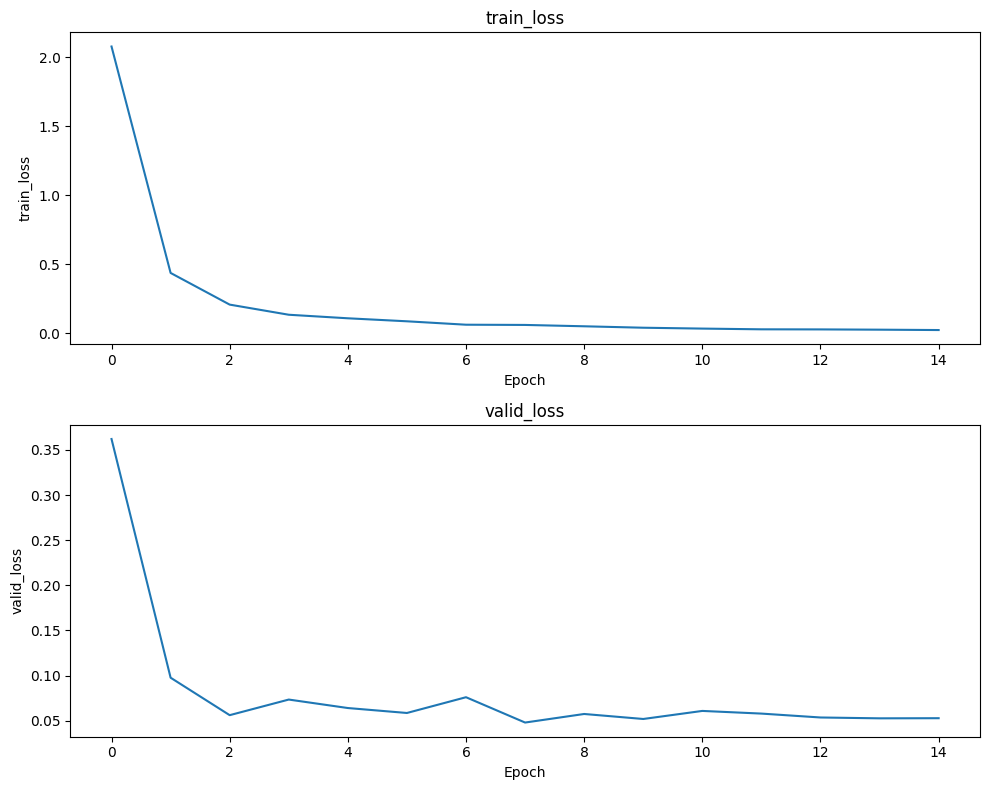

In [ ]:
# Define the metrics to plot
metrics = list(history.keys())
print(f'Metrics: {metrics} \tHistory size: {len(history[metrics[0]])}')

# Plot each metric in a separate subplot
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8))
for i, metric in enumerate(metrics):
    axs[i].plot(history[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, training loss: 2.0770


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1, validation loss: 0.3621


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, training loss: 0.4355


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2, validation loss: 0.0976


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, training loss: 0.2058


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3, validation loss: 0.0561


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, training loss: 0.1324


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4, validation loss: 0.0734


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, training loss: 0.1067


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5, validation loss: 0.0640


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, training loss: 0.0849


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6, validation loss: 0.0585


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, training loss: 0.0601


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7, validation loss: 0.0760


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, training loss: 0.0585


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8, validation loss: 0.0479


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, training loss: 0.0487


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9, validation loss: 0.0574


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10, training loss: 0.0383


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10, validation loss: 0.0519


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 11, training loss: 0.0320


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11, validation loss: 0.0608


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 12, training loss: 0.0267


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12, validation loss: 0.0579


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 13, training loss: 0.0261


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13, validation loss: 0.0535


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 14, training loss: 0.0241


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14, validation loss: 0.0526


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 15, training loss: 0.0215


Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15, validation loss: 0.0527


In [ ]:
# !cp model_output/epoch_8/passages/* /content/drive/MyDrive/temp/passages/
# !cp model_output/epoch_8/queries/*  /content/drive/MyDrive/temp/queries/